In [1]:
#Downloading necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import time
#Below makes potential false error not showing
pd.options.mode.chained_assignment = None

#Below allaws for printing many results not only last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#loading data into 'data' object of type DataFrame. Changing calumns' names.
data = pd.read_csv("data_total.csv")
data.columns = ['Date', 'Open', 'High', 'Low','Close','Volume']

#Introducing typical price vector being average of 'Close', 'High' and 'Low'. 
data['Price'] = round((data["Close"]+data["High"]+data["Low"])/3,2)
#data.set_index('Date', inplace=True)

#Deleting redundant columns
data=data.drop(['Volume','Open', 'High', 'Low','Close'],1)

#adding array which is daily gross returns
data['Daily returns'] = data['Price']/data['Price'].shift(1)-1

#descriptive statistics of daily returns
(data['Daily returns'].describe()).round(decimals=4)

count    5677.0000
mean        0.0002
std         0.0124
min        -0.1063
25%        -0.0059
50%         0.0007
75%         0.0064
max         0.0933
Name: Daily returns, dtype: float64

In [2]:
#Spliting Data into training and testing sets
data_training = data.iloc[:5076]
data_testing = data.iloc[5076:]

#Converting Date column to datatype of date
data_training['Date'] = pd.to_datetime(data_training['Date']).dt.strftime('%d/%m/%Y')
data_testing['Date'] = pd.to_datetime(data_training['Date']).dt.strftime('%d/%m/%Y')

data_testing=data_testing.reset_index() 

#Create a copy of data
strategies = data_training

In [3]:
#Auxilary functions of rolling SMA and STD
def get_sma(prices, window):
    return prices.rolling(window,min_periods=window).mean()

def get_std(prices,window):
    return prices.rolling(window,min_periods=window).std()

In [4]:
#Bollinger Bands function
def get_bollinger_bands(prices, window, sigma):
    data = prices['Price']
    
    #calculate rolling Simple Moving Average and rolling standard deviation on 'Price' array
    Roll_SMA = pd.Series(round((get_sma(data,window)),2), name='Roll_SMA')
    Roll_STD = round(get_std(data,window),2)
    
    #calculate bollinger bands based on rolling SMA and standard deviation
    Bollinger_up = pd.Series(round((Roll_SMA + Roll_STD * sigma),2), name='Bollinger_up') 
    Bollinger_down = pd.Series(round((Roll_SMA - Roll_STD * sigma),2), name='Bollinger_down')
    
    #concatenates bands' arrays to input data set
    prices=pd.concat([prices, Roll_SMA,Bollinger_up,Bollinger_down], axis=1)    
    return prices
strategies = get_bollinger_bands(strategies,150,1)

In [5]:
#Slightly modified function solely used for plotting
def plot_signal_function(prices):
    buy_signal = []
    sell_signal = []
    
    #loop to create signals 
    for i in range(len(prices['Price'])):
        if prices['Price'][i] > prices['Bollinger_up'][i]:          
            buy_signal.append(prices['Price'][i])
            sell_signal.append(np.nan)
            
        elif prices['Price'][i] < prices['Bollinger_down'][i]:        
            buy_signal.append(np.nan)
            sell_signal.append(prices['Price'][i])  
            
        else:
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)
    
    #converting lists to Series datatype
    buy_signal = pd.Series(buy_signal, name='Buy_signal')
    sell_signal = pd.Series(sell_signal, name='Sell_signal')
    
    #concatenates bands' arrays to input data set
    prices=pd.concat([prices, buy_signal,sell_signal], axis=1)     
    return prices
BB_signal = plot_signal_function(strategies)

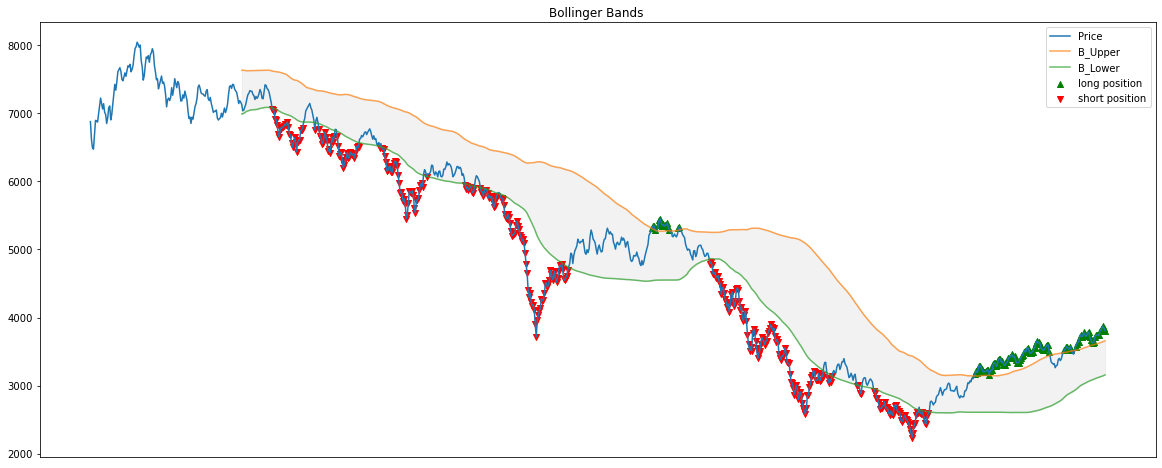

In [6]:
#plotting Bollinger bands for first 1000 observations
def plot_strategies(df):
    plt.figure(figsize=(20,8))
    plt.title('Bollinger Bands ')
    plt.plot(df['Date'], df['Price'], label='Price')

    plt.plot(df['Date'], df['Bollinger_up'], label='B_Upper', alpha=0.7)
    plt.plot(df['Date'], df['Bollinger_down'], label='B_Lower', alpha=0.7)
    plt.fill_between(df['Date'], df['Bollinger_up'], df['Bollinger_down'], color='grey', alpha=0.1)

    plt.scatter(df['Date'], df['Buy_signal'], label='long position', marker='^', color='g')
    plt.scatter(df['Date'], df['Sell_signal'], label='short position', marker='v',color='r')
    
    plt.xticks([])
    plt.legend()
    
    plt.show()
plot_strategies(BB_signal[:1000])

# The below graph represents your position relative to buy/sell signals such that if the daily price is below the lower
# BB (sell); if price > upper_BB (buy); if lower_BB < price < upper_BB (market neutral)

In [7]:
#Bollinger band's position function
def poz_boll(prices):
    position = []  
    
    #loop creating postitions (1,0,-1) based on previously calculated bollinger bands
    for i in range(len(prices['Price'])):
        if prices['Price'][i] > prices['Bollinger_up'][i]:          
            position.append(1)            
        elif prices['Price'][i] < prices['Bollinger_down'][i]:        
            position.append(-1)
        else:
            position.append(0)
    
    #converting list to Series datatype
    position = pd.Series(position, name='Position boll')
    
    #concatenates position array to input data set
    prices=pd.concat([prices, position], axis=1)       
    return prices
strategies = poz_boll(strategies)

In [8]:
#function which calculates PNL from Bollinger Bands' investment strategy
def pnl_boll(df):
    
    #creating arrays of gross PNL and Net Equity Line
    df['Gross PNL Boll'] = round(df['Position boll'] * df['Daily returns'],2)
    df['Net Equity Line Boll']=50000.00
    
    #adjusting values of Net Equity Line based on previously taken positions and daily Gross PNL
    for i in range(1, len(df)-1):
        #iterating position over values different than zero
        if df['Position boll'][i] != 0:
            if df['Position boll'][i] == df['Position boll'][i-1]:
                #below helps to avoid problem when taking last index into account
                if i==5075:
                    df['Net Equity Line Boll'][i]=df['Net Equity Line Boll'][i-1]
                else:
                    if df['Position boll'][i-1] ==1:
                        df['Net Equity Line Boll'][i] = round((df['Net Equity Line Boll'][i-1])
                                                              * (1+df['Daily returns'][i+1]),2)
                    else:
                        df['Net Equity Line Boll'][i] = round((df['Net Equity Line Boll'][i-1])
                                                              * (1-df['Daily returns'][i+1]),2)
            else:
                df['Net Equity Line Boll'][i] = round((df['Net Equity Line Boll'][i-1])
                                                      *0.9963 * (1+df['Daily returns'][i]),2)
        #iterating position over values equal zero
        else:
            if df['Position boll'][i] == df['Position boll'][i-1]:
                df['Net Equity Line Boll'][i] = df['Net Equity Line Boll'][i-1]
            else:
                df['Net Equity Line Boll'][i] = round((df['Net Equity Line Boll'][i-1])*0.9963,2)
#calculating daily returns of Bolliner Band's strategy
    df['Daily returns Boll'] = df['Net Equity Line Boll']/df['Net Equity Line Boll'].shift(1)-1
    df['Net Equity Line Boll'].iloc[-1] = df['Net Equity Line Boll'].iloc[-2]
    return df
strategies = pnl_boll(strategies)   

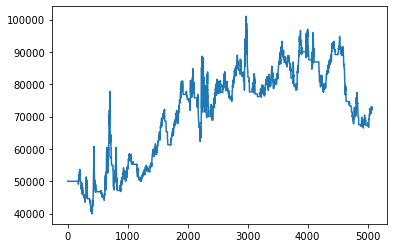

In [9]:
#ploting Net Equity Line
plt.plot(strategies['Net Equity Line Boll'], label='Net Equity Line Boll')
plt.show()

In [10]:
#Donchian Channels function
def Donchian_channels(df,window):
    #creation of empty lists
    channel_up=[]
    channel_down=[]
    channel_mid=[]
    
    #convertion to Series data type and applying rolling MIN and MAX methods
    channel_up = pd.Series(df['Price'].rolling(window,min_periods=window).max(), name='Channel up')
    channel_down = pd.Series(df['Price'].rolling(window,min_periods=window).min(), name='Channel down')   
    channel_mid= pd.Series(round((channel_up+channel_down)/2,2), name ='Channel mid')
    
    #concatenates channels arrays to input data set
    df=pd.concat([df, channel_up,channel_mid,channel_down], axis=1)       
    df=df.fillna(0)
    return df

strategies = Donchian_channels(strategies,100)

In [11]:
#Donchian Channels's signal function (1,0)
def position_don(df):
    #creating of empty signal list and appending first value with 0
    signal = []
    signal.append(0)
    
    #iterating over indices to calculate positions
    for i in range(1,len(df['Price'])):
        if df['Price'][i] > df['Channel mid'][i-1]:          
            signal.append(1)            
        else:
            signal.append(0)
            
    #convertion to Series data type   
    signal = pd.Series(signal, name='Position don')
    
    #concatenates position array to input data set
    df=pd.concat([df, signal], axis=1)         
    
    return df
strategies = position_don(strategies)

In [12]:
#function to calculate Net Equity Line and daily returns
def pnl_don(df):
    
    #creation of new column with default value
    df['Net Equity Line Don'] = 50000.00
    
    #iterating over indices without first and last values(so to avoid index errors)
    for i in range(1, len(df)-1):
        if df['Position don'][i] == 1:
            
            #appending Net equity line based on position and daily return
            if df['Position don'][i] == df['Position don'][i-1]:
                df['Net Equity Line Don'][i] = round((df['Net Equity Line Don'][i-1])
                                                     * (1+df['Daily returns'][i]),2)
            else:
                df['Net Equity Line Don'][i] = round((df['Net Equity Line Don'][i-1])
                                                     * 0.9963 * (1+round(df['Daily returns'][i],4)),2)
        else:
            if df['Position don'][i-1] ==1:
                df['Net Equity Line Don'][i] = round(df['Net Equity Line Don'][i-1]
                                                     *0.9963,2)
            else:
                df['Net Equity Line Don'][i]=df['Net Equity Line Don'][i-1]
                
    #populating last value with second to last value so to avoid index error
    df['Net Equity Line Don'].iloc[-1] = df['Net Equity Line Don'].iloc[-2]
    
    #calculating daily return array
    df['Daily returns Don'] = df['Net Equity Line Don']/df['Net Equity Line Don'].shift(1)-1
    return df
strategies= pnl_don(strategies)

In [13]:
#Slightly modified function solely used for plotting
def plot_signal_function(df):
    buy_signal = []
    sell_signal = []
    for i in range(1,len(df['Price'])):
        if df['Price'][i] > df['Channel mid'][i-1]:          
            buy_signal.append(df['Price'][i])
            sell_signal.append(np.nan)
        else:
            buy_signal.append(np.nan)
            sell_signal.append(df['Price'][i])
            
    buy_signal = pd.Series(buy_signal, name='Buy_signal')
    sell_signal = pd.Series(sell_signal, name='Sell_signal')  
    df=pd.concat([df, buy_signal,sell_signal], axis=1)
    
    return df
Donchian_signal = plot_signal_function(strategies)

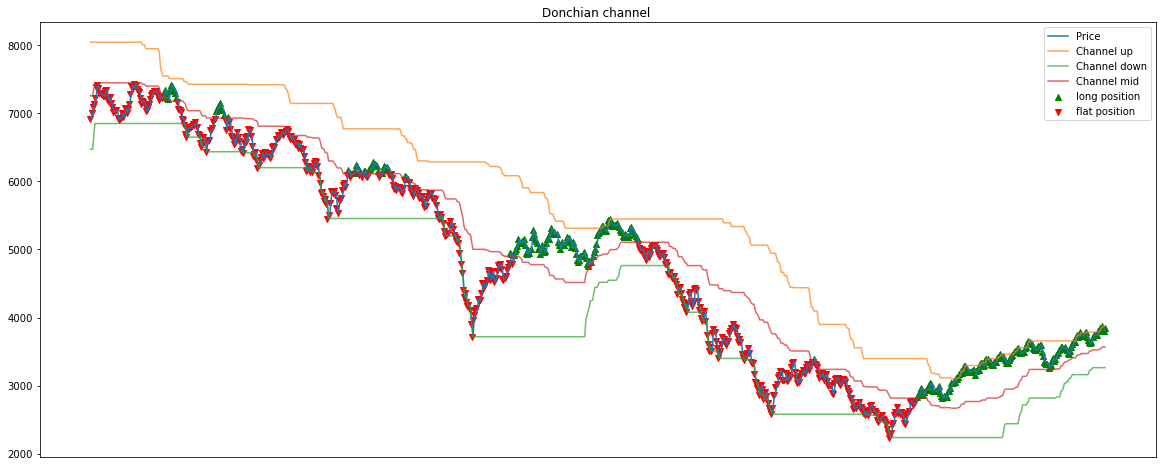

In [14]:
def plot_strategies(df):
    plt.figure(figsize=(20,8))
    plt.title('Donchian channel ')
    plt.plot(df['Date'], df['Price'], label='Price')

    plt.plot(df['Date'], df['Channel up'], label='Channel up', alpha=0.7)
    plt.plot(df['Date'], df['Channel down'], label='Channel down', alpha=0.7)
    plt.plot(df['Date'], df['Channel mid'], label='Channel mid', alpha=0.7)

    plt.scatter(df['Date'], df['Buy_signal'], label='long position', marker='^', color='g')
    plt.scatter(df['Date'], df['Sell_signal'], label='flat position', marker='v',color='r')
    
    plt.xticks([])
    plt.legend()
    
    plt.show()
plot_strategies(Donchian_signal[100:1000])

In [15]:
#calculating risk measures with distinction to which strategy we refer to
def sharpe_boll(df):
    CAGR=(df['Net Equity Line Boll'].iloc[-1]/df['Net Equity Line Boll'].iloc[0])**(1/19)-1
    volatility = df['Daily returns Boll'].std() * np.sqrt(252)
    sharpe_ratio_boll = (CAGR) / volatility
    return sharpe_ratio_boll
def sharpe_don(df):
    CAGR=(df['Net Equity Line Don'].iloc[-1]/df['Net Equity Line Don'].iloc[0])**(1/19)-1
    volatility = df['Daily returns Don'].std() * np.sqrt(252)
    sharpe_ratio_don = (CAGR) / volatility
    return sharpe_ratio_don

def information_ratio_boll(df):
    return_difference = df['Daily returns Boll'] - df['Daily returns']
    volatility = return_difference.std() * np.sqrt(252)
    information_ratio = return_difference.mean() / volatility
    return information_ratio
def information_ratio_don(df):
    return_difference = df['Daily returns Don'] - df['Daily returns']
    volatility = return_difference.std() * np.sqrt(252)
    information_ratio = return_difference.mean() / volatility
    return information_ratio

def max_drawdown_boll(df,window):
    Roll_Max = df['Net Equity Line Boll'].rolling(window, min_periods=1).max()
    Roll_Min = df['Net Equity Line Boll'].rolling(window, min_periods=1).min()
    Daily_Drawdown = Roll_Min/Roll_Max - 1.0
    result = round(Daily_Drawdown.min(),2)
    return result
def max_drawdown_don(df,window):
    Roll_Max = df['Net Equity Line Don'].rolling(window, min_periods=1).max()
    Roll_Min = df['Net Equity Line Don'].rolling(window, min_periods=1).min()
    Daily_Drawdown = df['Net Equity Line Don']/Roll_Max - 1.0
    result = round(Daily_Drawdown.min(),2)
    return result

In [16]:
#Creating loop for Bollinger Bands and Donchian channel
sigma = pd.Series([1])
window = pd.Series([ 5, 10, 15, 20, 50, 100, 150, 200, 250])
final_results=pd.DataFrame(columns=['Window', 'sigma', 'SR boll','SR don','IR boll','IR don','MD boll','MD don','STD_boll','STD_don'])

#taking every element from both lists and iterating over strategy functions
for i in window:
    for j in sigma:
        strategies = data_training
        strategies = get_bollinger_bands(strategies,i,j) 
        strategies = poz_boll(strategies)
        strategies = pnl_boll(strategies)
        strategies = Donchian_channels(strategies,i) #window
        strategies = position_don(strategies)
        strategies = pnl_don(strategies)
        
        #calculating risk-adjusted metrics
        SR_boll=sharpe_boll(strategies)
        SR_don=sharpe_don(strategies)
        IR_boll=information_ratio_boll(strategies)
        IR_don=information_ratio_don(strategies)
        MD_boll=max_drawdown_boll(strategies,100)
        MD_don=max_drawdown_don(strategies,100)
        STD_boll=strategies['Daily returns Boll'].std()
        STD_don=strategies['Daily returns Don'].std()

        #wrapping up iterated results of risk-adjusted metrics
        final_results.loc[len(final_results.index)] = [i, j, SR_boll,SR_don,IR_boll,IR_don,MD_boll,MD_don,STD_boll,STD_don]     

In [17]:
strategies.to_csv('strategies.csv', index=False)

In [18]:
final_results.to_csv('final_results_in_sample.csv', index=False)

In [19]:
print(final_results)

   Window  sigma   SR boll    SR don   IR boll    IR don  MD boll  MD don  \
0     5.0    1.0 -0.002040  6.769337  0.000874  0.015372    -0.44   -0.06   
1    10.0    1.0 -0.010860  4.873187  0.000831  0.010624    -0.35   -0.06   
2    15.0    1.0 -0.012464  3.874550  0.000823  0.008290    -0.39   -0.07   
3    20.0    1.0 -0.026810  3.282397  0.000749  0.006909    -0.44   -0.08   
4    50.0    1.0 -0.078155  2.051048  0.000434  0.003939    -0.38   -0.10   
5   100.0    1.0 -0.118967  1.540995 -0.000451  0.002690    -0.41   -0.15   
6   150.0    1.0  0.114645  1.369134 -0.000541  0.002387    -0.43   -0.15   
7   200.0    1.0 -0.086667  1.153409 -0.000526  0.001873    -0.41   -0.16   
8   250.0    1.0  0.151938  0.998728 -0.000471  0.001511    -0.41   -0.17   

   STD_boll   STD_don  
0  8.889734  0.007434  
1  1.216998  0.007278  
2  1.024442  0.007214  
3  0.377554  0.007188  
4  0.073899  0.007064  
5  0.013026  0.007000  
6  0.010847  0.007151  
7  0.011355  0.007179  
8  0.011706  

In [20]:
#redefining Sharp'e ratio functions and pnl boll
def sharpe_boll(df):
    CAGR=(df['Net Equity Line Boll'].iloc[-1]/df['Net Equity Line Boll'].iloc[0])**(1/2)-1
    volatility = df['Daily returns Boll'].std() * np.sqrt(252)
    sharpe_ratio_boll = (CAGR) / volatility
    return sharpe_ratio_boll
def sharpe_don(df):
    CAGR=(df['Net Equity Line Don'].iloc[-1]/df['Net Equity Line Don'].iloc[0])**(1/2)-1
    volatility = df['Daily returns Don'].std() * np.sqrt(252)
    sharpe_ratio_don = (CAGR) / volatility
    return sharpe_ratio_don

#redefining pnl_boll function
def pnl_boll(df):
    
    #creating arrays of gross PNL and Net Equity Line
    df['Gross PNL Boll'] = round(df['Position boll'] * df['Daily returns'],4)
    df['Net Equity Line Boll']=50000.00
    
    #adjusting values of Net Equity Line based on previously taken positions and daily Gross PNL
    for i in range(1, len(df)):
        if df['Position boll'][i] != 0:
            if df['Position boll'][i] == df['Position boll'][i-1]:
                if i==601:
                    df['Net Equity Line Boll'][i]=df['Net Equity Line Boll'][i-1]
                else:
                    if df['Position boll'][i-1] ==1:
                        df['Net Equity Line Boll'][i] = round((df['Net Equity Line Boll'][i-1]) * (1+df['Daily returns'][i+1]),2)
                    else:
                        df['Net Equity Line Boll'][i] = round((df['Net Equity Line Boll'][i-1]) * (1-df['Daily returns'][i+1]),2)
            else:
                df['Net Equity Line Boll'][i] = round((df['Net Equity Line Boll'][i-1])*0.9963 * (1+df['Daily returns'][i+1]),2)
        else:
            if df['Position boll'][i] == df['Position boll'][i-1]:
                df['Net Equity Line Boll'][i] = df['Net Equity Line Boll'][i-1]
            else:
                df['Net Equity Line Boll'][i] = round((df['Net Equity Line Boll'][i-1])*0.9963,2)
#calculating daily returns of Bolliner Band's strategy
    df['Daily returns Boll'] = df['Net Equity Line Boll']/df['Net Equity Line Boll'].shift(1)-1
    df['Net Equity Line Boll'].iloc[-1] = df['Net Equity Line Boll'].iloc[-2]
    return df

In [21]:
#implementing best parameters set to testing data
results_testing=pd.DataFrame(
    columns=['Window', 'sigma', 'SR boll','SR don','IR boll','IR don','MD boll','MD don','STD_boll','STD_don'])

#calculating positions and PNL
strategies = data_testing
strategies = get_bollinger_bands(strategies,150,1) 
strategies = poz_boll(strategies)
strategies = pnl_boll(strategies)
strategies = Donchian_channels(strategies,5) #window
strategies = position_don(strategies)
strategies = pnl_don(strategies)

#calculating risk-adjusted metrics
SR_boll=sharpe_boll(strategies)
SR_don=sharpe_don(strategies)
IR_boll=information_ratio_boll(strategies)
IR_don=information_ratio_don(strategies)
MD_boll=max_drawdown_boll(strategies,100)
MD_don=max_drawdown_don(strategies,100)
STD_boll=strategies['Daily returns Don'].std()
STD_don=strategies['Daily returns Boll'].std()

#wrapping up results of risk-adjusted metrics
results_testing.loc[len(results_testing.index)] = [150, 1, SR_boll,SR_don,IR_boll,IR_don,MD_boll,MD_don,STD_boll,STD_don]

In [24]:
results_testing.to_csv('final_results_outof_sample.csv', index=False)
print(results_testing)

   Window  sigma   SR boll    SR don   IR boll    IR don  MD boll  MD don  \
0   150.0    1.0 -1.236367  6.932986 -0.002671  0.012948    -0.23   -0.03   

   STD_boll   STD_don  
0  0.008938  0.007532  


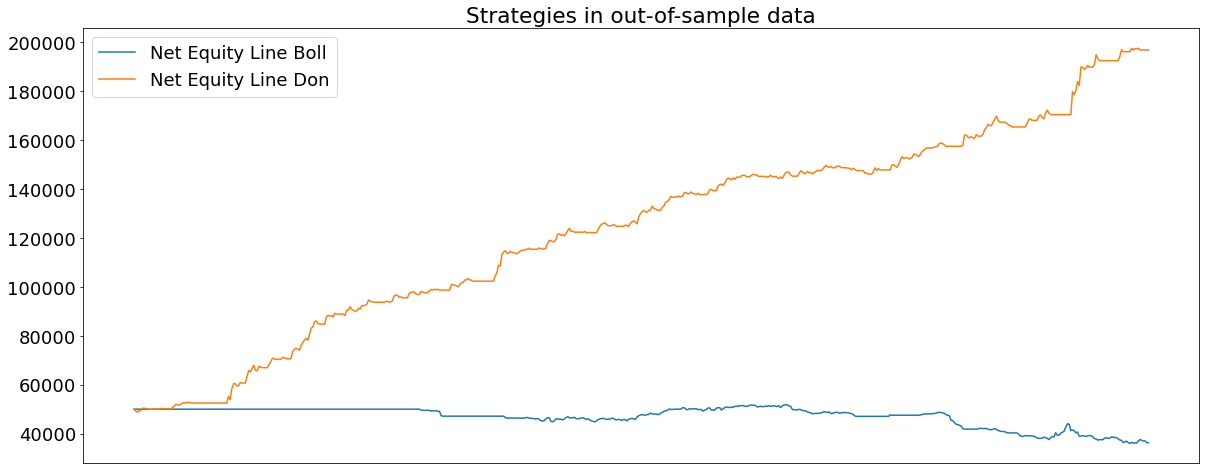

In [23]:
def plot_results(df):
    plt.figure(figsize=(20,8))
    plt.rcParams.update({'font.size': 18})
    plt.title('Strategies in out-of-sample data')
    plt.plot(df['Net Equity Line Boll'], label='Net Equity Line Boll')
    plt.plot(df['Net Equity Line Don'], label='Net Equity Line Don')
    plt.xticks([])
    plt.legend()
    plt.savefig('books_read.png')
    plt.show()
plot_results(strategies)